# Logistic Regression (applied to dummy data)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

# Load data and plot

In [3]:
# init data object
data_obj = Data('./dummy_data_b.csv', 'label', -1)
data = data_obj.data
data.head(5)

,200,202,204,206,208,210,212,214,216,218,...,384,386,388,390,392,394,396,398,400,label
0,43.299122,44.990818,44.149924,41.440046,43.606651,40.901448,42.791861,40.481541,42.917414,39.070079,...,59.782275,58.931280,62.423990,59.374885,61.158376,63.762961,62.499685,64.084609,61.916455,A
5,42.677437,44.349136,43.800291,41.971019,41.395425,43.590253,40.433239,40.328223,41.271485,40.870063,...,57.431210,58.788641,58.505568,61.712110,60.390301,63.020351,63.509685,62.219441,60.184378,A
34,40.672725,42.299050,40.152235,42.136258,41.635476,39.933541,41.596809,40.359753,38.720161,37.622693,...,54.143240,53.767697,55.532082,57.267862,59.626443,61.730520,61.768051,59.238203,62.367902,B
13,41.252282,44.272045,42.421165,40.622308,43.682976,45.042767,43.863577,40.116367,41.790624,39.118865,...,58.184079,60.145286,61.827041,63.291666,60.041874,63.831761,60.720013,59.297022,61.126032,A
45,41.188936,44.233271,43.392674,40.494337,44.005415,41.531073,38.253897,37.180235,39.702793,37.509966,...,52.781690,52.333778,57.050118,56.582997,55.838880,57.855655,61.664946,60.839299,61.616428,B


A: blue
B: red


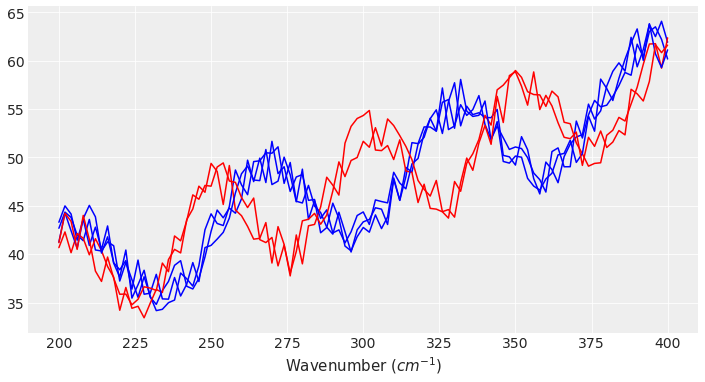

In [4]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 5)

In [5]:
# number of samples from each class
data['label'].value_counts()

B    30
A    29
Name: label, dtype: int64

In [6]:
# retrieve a list of k-fold training and test sets
train_lst, test_lst = utl.train_test_split_kfold(data, 3)

In [7]:
train_lst[0].shape

(39, 102)

In [8]:
test_lst[0].shape

(20, 102)

# Model definition (Multiple Logistic Regression)

In [9]:
traces = []

print("Training model with k-fold cross validation")

# loop over n-training sets
for i in range(len(train_lst)):
    print("training on fold: " + str(i+1) + "/" + str(len(train_lst)))
    
    # prepare training data
    Y = pd.Categorical(train_lst[i][label_col]).codes
    x_n = train_lst[i].columns[:non_data_cols]
    x_s = train_lst[i][x_n].values
    x_s = utl.standardize(x_s)
    
    # train model and store traces
    with pm.Model() as model_mlr: 
        alpha = pm.Normal('alpha', mu=0, sd=10)
        beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
        mu = alpha + pm.math.dot(x_s, beta)
        theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
        y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y)

        trace_mlr = pm.sample(2000, random_seed=42)    
        traces.append(trace_mlr)

Training model with k-fold cross validation (k=) 3
training on fold: 1/3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:22<00:00, 60.87draws/s]


training on fold: 2/3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:19<00:00, 62.50draws/s]


training on fold: 3/3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:20<00:00, 62.35draws/s]


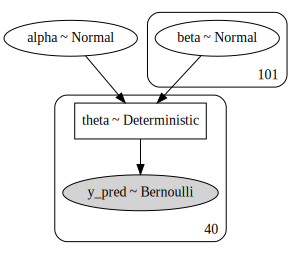

In [10]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [11]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.414,9.585,-17.055,18.776,0.146,0.144,4295.0,2218.0,4293.0,2963.0,1.0
beta[0],0.312,9.783,-16.989,19.203,0.140,0.172,4905.0,1610.0,4932.0,2699.0,1.0
beta[1],0.100,9.742,-17.923,18.773,0.145,0.187,4538.0,1363.0,4542.0,2868.0,1.0
beta[2],-0.652,9.499,-18.629,16.934,0.140,0.155,4633.0,1869.0,4632.0,2984.0,1.0
beta[3],-0.844,9.339,-18.600,16.505,0.141,0.158,4368.0,1744.0,4371.0,2681.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[96],-1.699,9.659,-19.348,16.871,0.130,0.169,5518.0,1635.0,5517.0,2915.0,1.0
beta[97],-1.902,9.853,-19.742,16.573,0.144,0.159,4666.0,1916.0,4666.0,2802.0,1.0
beta[98],-0.982,9.300,-19.191,15.364,0.129,0.152,5215.0,1863.0,5232.0,3129.0,1.0
beta[99],-0.086,9.294,-17.799,16.544,0.129,0.153,5207.0,1844.0,5228.0,2912.0,1.0


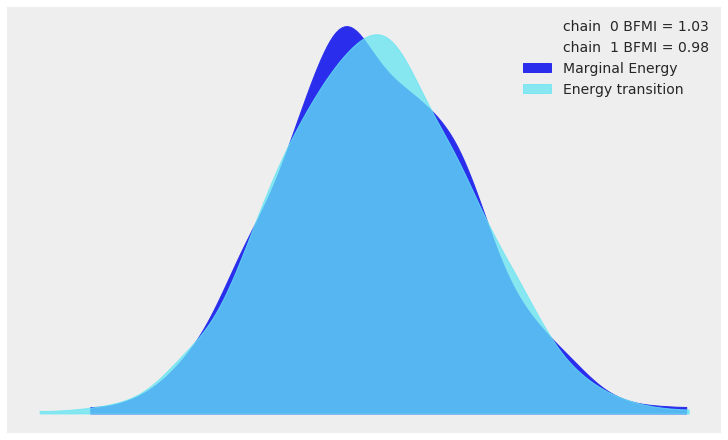

In [12]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [13]:
# add model predictions on test dataset
for i in range(len(traces)):
    test_lst[i] = utl.append_predictions(data_obj, traces[i], test_lst[i], display=False)

In [14]:
# prediction score on test dataset
utl.logistic_score(test_lst, 'label', 'p_label', kfold=True)

n   tot  cor  err  score (%)
----------------------------
1    20   20   0   100.0
2    20   20   0   100.0
3    19   19   0   100.0
----------------------------
tot  59   59   0   100.0


In [15]:
# save trace
#pm.backends.text.dump('./traces/trace_dummy', trace_mlr)